In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [53]:
df = pd.read_excel("BaseFeaturesHH.xlsx")
df = df.drop('Unnamed: 0', axis = 1)
df

,From Timestamp,HH Electricity (kWh),dayofweek,hour,holiday,month,Temperature (C),Feels like (C),Humidity (%)
0,2018-01-01 00:00:00,12.80,0,0.0,1,1,6.4,1.9,82.76
1,2018-01-01 00:30:00,12.30,0,0.5,1,1,6.4,1.9,82.76
2,2018-01-01 01:00:00,13.50,0,1.0,1,1,6.6,2.4,80.14
3,2018-01-01 01:30:00,11.90,0,1.5,1,1,6.6,2.4,80.14
4,2018-01-01 02:00:00,12.80,0,2.0,1,1,6.1,2.0,84.33
...,...,...,...,...,...,...,...,...,...
35035,2019-12-31 21:30:00,13.56,1,21.5,0,12,6.5,3.3,88.23
35036,2019-12-31 22:00:00,13.81,1,22.0,0,12,6.6,4.4,87.69
35037,2019-12-31 22:30:00,14.12,1,22.5,0,12,6.6,4.4,87.69
35038,2019-12-31 23:00:00,14.50,1,23.0,0,12,6.7,4.1,88.13


In [54]:
lagNumberStart = 1
lagNumberEnd = 8

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    df[name] = df['HH Electricity (kWh)'].shift(48*i)

i = list(range(lagNumberEnd*48))
df = df.drop(i)


feature_cols = ['dayofweek', 'hour', 'month', 'holiday', 'Temperature (C)', 'Feels like (C)', 'Humidity (%)']   

for i in range(lagNumberStart, lagNumberEnd):
    name = "n-{}.".format(48*i)
    feature_cols.append(name)
    
X = df[feature_cols].copy() #input features for fitting
Y = df['HH Electricity (kWh)']

size = -int(len(df)*0.2)

Xinput = df.iloc[:size]
Xtest = df.iloc[size:] # 20%

size2 = -int(len(Xinput)*0.25)

Xtrain = Xinput.iloc[:size2].copy() #60%
Xvalidate = Xinput.iloc[size2:].copy() #20%

trainX = Xtrain[feature_cols] # Features
trainy = Xtrain['HH Electricity (kWh)'] # Target variable

validateX = Xvalidate[feature_cols] # Features
validatey = Xvalidate['HH Electricity (kWh)'] # Target variable

testX = Xtest[feature_cols] # Features
testy = Xtest['HH Electricity (kWh)'] # Target variable

inputX = Xinput[feature_cols] # Features
inputy = Xinput['HH Electricity (kWh)'] # Target variable

scaler = StandardScaler() #scaling
scaler.fit(X)
trainXscaled = scaler.transform(trainX)
validateXscaled = scaler.transform(validateX)
testXscaled = scaler.transform(testX)
inputXscaled = scaler.transform(inputX)



In [55]:
Xinput.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
HH Electricity (kWh),27725.0,16.803685,5.644138,9.00,12.50,14.72,20.41,41.59
dayofweek,27725.0,2.995852,1.996214,0.00,1.00,3.00,5.00,6.00
hour,27725.0,11.745032,6.926225,0.00,5.50,11.50,17.50,23.50
holiday,27725.0,0.020775,0.142634,0.00,0.00,0.00,0.00,1.00
month,27725.0,5.704310,3.198231,1.00,3.00,5.00,8.00,12.00
Temperature (C),27725.0,11.271877,6.030412,-5.50,7.10,10.70,15.70,30.50
Feels like (C),27725.0,10.022593,7.330152,-12.50,4.40,10.70,15.70,30.90
Humidity (%),27725.0,79.592207,14.143224,29.22,70.92,83.23,90.80,100.00
n-48.,27725.0,16.812494,5.651675,9.00,12.50,14.75,20.41,41.59
n-96.,27725.0,16.809818,5.652244,9.00,12.50,14.72,20.41,41.59


### Adding normalization layer to the model

In [56]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(inputX))

# Creating the model

In [57]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])


In [58]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_percentage_error')



In [59]:
history = linear_model.fit(
    inputX,
    inputy,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.25)

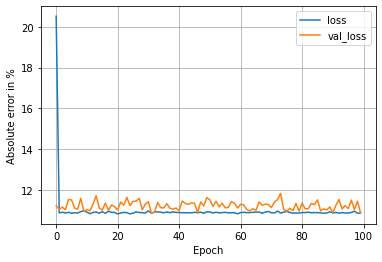

In [60]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Absolute error in %')
  plt.legend()
  plt.grid(True)

plot_loss(history)


Why is there no learning curve?

In [61]:
test_results={}
test_results['linear_model'] = linear_model.evaluate(testX, testy, verbose=0)

In [62]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_percentage_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model



In [63]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 14)               29        
 ion)                                                            
                                                                 
 dense_11 (Dense)            (None, 64)                960       
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,214
Trainable params: 5,185
Non-trainable params: 29
_________________________________________________________________


In [64]:
%%time
history = dnn_model.fit(
    inputX,
    inputy,
    validation_split=0.25,
    verbose=0, epochs=100)


Wall time: 1min 26s


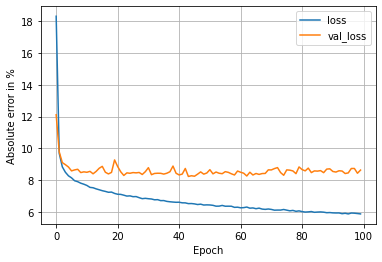

In [65]:
plot_loss(history)

In [66]:
test_results['dnn_model'] = dnn_model.evaluate(testX, testy, verbose=0)

In [67]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T


,Mean absolute error [MPG]
linear_model,10.305903
dnn_model,10.974210


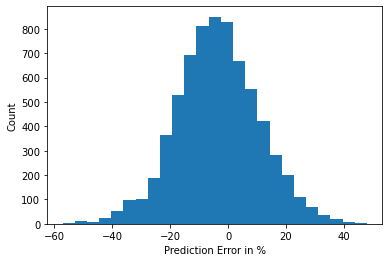

In [70]:
error = 100*(test_predictions - testy)/testy
plt.hist(error, bins=25)
plt.xlabel('Prediction Error in %')
_ = plt.ylabel('Count')


# Results are disappointing


In [71]:
pip install -q -U keras-tuner

Note: you may need to restart the kernel to use updated packages.
